Advanced Topics and Plans
====================================

Capabilities not yet covered
-----------------------------------------

- Serializing analytic models without pickle
- When arrays are loaded
- Memory mapping
- Handling in-line vs binary array choices
  - E.g., files editable with a text editor
  - Easily printed out
  - Enables scientists to use own code to read contents without ASDF libraries
- Handling compression of arrays


Serializing Models
---------------------------

Uses astropy models

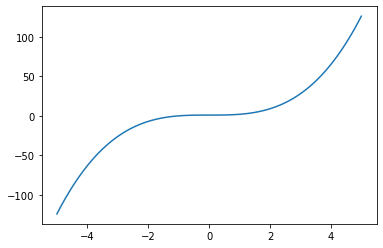

In [1]:
import os
import astropy.modeling.models as amm
import numpy as np
import asdf
from matplotlib import pyplot as plt

# Create a simple model

poly_model = amm.Polynomial1D(degree=3, c0=1.0, c3=1.0)
poly_model.coeff = (1.0, 0.0, 0.0, 1.0)
x = np.linspace(-5, 5, 101)
plt.plot(x, poly_model(x))

In [2]:
af = asdf.AsdfFile()
af.tree = {"model": poly_model}
af.write_to("model.asdf")
af2 = asdf.open("model.asdf")
poly_model2 = af2.tree["model"]
print(poly_model2(x) - poly_model(x))

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0.]


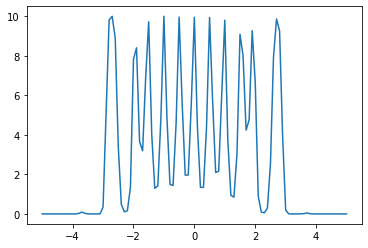

In [3]:
# Compound model example
compound = (
    poly_model + amm.Sine1D(amplitude=20.0, frequency=1.0, phase=0.0)
) | amm.Gaussian1D(amplitude=10.0, mean=0.0, stddev=10.0)
plt.plot(x, compound(x))

In [4]:
af.tree = {"compound": compound}
af.write_to("compound.asdf", all_array_storage="inline")
with open("compound.asdf", "rb") as asdftext:
    text = asdftext.read()
    print(text.decode("utf-8"))

#ASDF 1.0.0
#ASDF_STANDARD 1.5.0
%YAML 1.1
%TAG ! tag:stsci.edu:asdf/
--- !core/asdf-1.1.0
asdf_library: !core/software-1.0.0 {author: The ASDF Developers, homepage: 'http://github.com/asdf-format/asdf',
  name: asdf, version: 2.12.0}
history:
  extensions:
  - !core/extension_metadata-1.0.0
    extension_class: asdf.extension.BuiltinExtension
    software: !core/software-1.0.0 {name: asdf, version: 2.12.0}
  - !core/extension_metadata-1.0.0
    extension_class: asdf.extension._manifest.ManifestExtension
    extension_uri: asdf://asdf-format.org/transform/extensions/transform-1.5.0
    software: !core/software-1.0.0 {name: asdf-astropy, version: 0.2.1}
compound: !transform/compose-1.2.0
  forward:
  - !transform/add-1.2.0
    forward:
    - !transform/polynomial-1.2.0
      coefficients: !core/ndarray-1.0.0
        data: [1.0, 0.0, 0.0, 1.0]
        datatype: float64
        shape: [4]
      domain: &id001 [-1, 1]
      inputs: [x]
      outputs: [y]
      window: *id001
    - !transfo

Controlling how arrays are stored
-----------------------------------------

**inline vs binary**

Arrays may be stored one of two ways. By default they will be stored as binary blocks. But it is possible to save them in the YAML itself. The following illustrates the various ways that can be done.

*Globally selecting inline storage*

That is, all arrays will be stored in the YAML

In [5]:
a = np.arange(10)
b = np.zeros((5, 5))
tree = {"a": a, "b": b}
af = asdf.AsdfFile(tree)
af.write_to("inline.asdf", all_array_storage="inline")
text = open("inline.asdf").read()
print(text)

#ASDF 1.0.0
#ASDF_STANDARD 1.5.0
%YAML 1.1
%TAG ! tag:stsci.edu:asdf/
--- !core/asdf-1.1.0
asdf_library: !core/software-1.0.0 {author: The ASDF Developers, homepage: 'http://github.com/asdf-format/asdf',
  name: asdf, version: 2.12.0}
history:
  extensions:
  - !core/extension_metadata-1.0.0
    extension_class: asdf.extension.BuiltinExtension
    software: !core/software-1.0.0 {name: asdf, version: 2.12.0}
a: !core/ndarray-1.0.0
  data: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
  datatype: int64
  shape: [10]
b: !core/ndarray-1.0.0
  data:
  - [0.0, 0.0, 0.0, 0.0, 0.0]
  - [0.0, 0.0, 0.0, 0.0, 0.0]
  - [0.0, 0.0, 0.0, 0.0, 0.0]
  - [0.0, 0.0, 0.0, 0.0, 0.0]
  - [0.0, 0.0, 0.0, 0.0, 0.0]
  datatype: float64
  shape: [5, 5]
...



*Selecting specific array to store inline*

In [6]:
af.set_array_storage(b, "inline")
af.set_array_storage(a, "internal")
af.write_to("partial_inline.asdf")
text = open("partial_inline.asdf", "rb").read(768)
print(text.decode("utf-8"))

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xd3 in position 719: invalid continuation byte

**Compression options**

Currently two block compression options are available. As with the inline vs internal, this can be done globally or for specific arrays. Current options are `'zlib'` or `'bzp2'`

*global compression example*

Where all arrays are stored inline

In [ ]:
af = asdf.AsdfFile()
a = np.arange(10)
b = np.zeros(100000)
af.tree = {"a": a, "b": b}
af.write_to("all_compressed.asdf", all_array_compression="zlib")
bcontent = open("all_compressed.asdf", "rb").read()
print(len(bcontent))  # note much smaller than 800000 bytes
af2 = asdf.open("all_compressed.asdf")
print(af2.tree["b"].shape)

*specific array compression*

In [ ]:
af = asdf.AsdfFile()
a = np.arange(10)
b = np.zeros(100000)
af.tree = {"a": a, "b": b}
af.set_array_compression(b, "bzp2")
af.write_to("selected_compressed.asdf")
bcontent = open("selected_compressed.asdf", "rb").read()
print(len(bcontent))  # note much smaller than 800000 bytes
af2 = asdf.open("selected_compressed.asdf")
print(af2.tree["b"].shape)

Plans for Development
-------------------------------

- Support for fsspec for cloud usage (probably based on zarr and possibly DASK)
- Support for chunking (also based on zarr, incorporate into zarr itself)
  - Improved block management
- More compression options, mostly based on BLOSC
- C/C++ support (initially through Python, but ideally as a native library)
- Schema information retrieval, e.g., get description associated with an attribute
- Support custom validators

Questions?
------------------

Exercises
---------------

1. Write a C or C++ library to read and write ASDF files. Provide documentation and a full test suite.

Bonus: support all astropy models.